# DoWhy-The Causal Story Behind Hotel Booking Cancellations

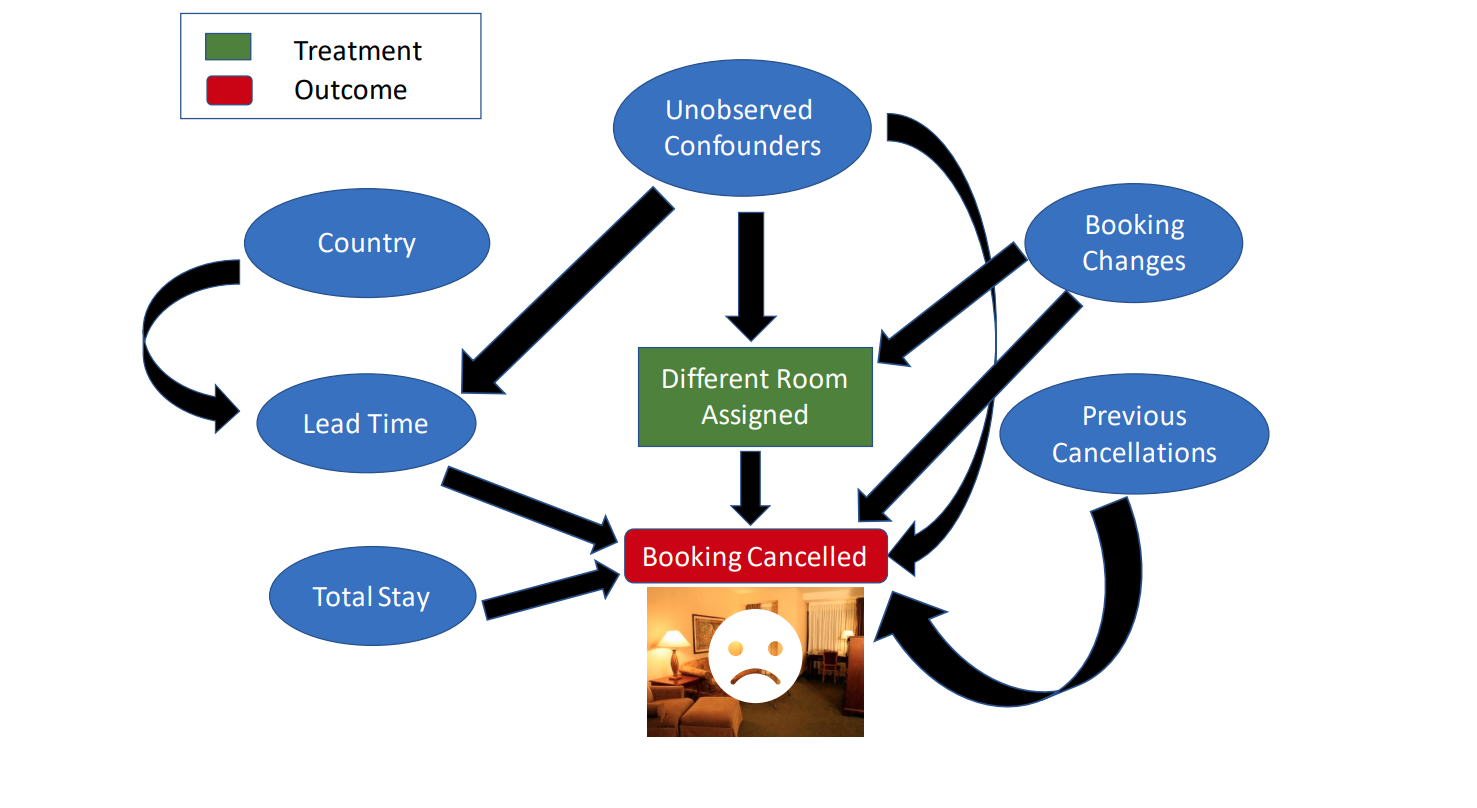

We consider the problem of estimating what impact does assigning a room different to what a customer had reserved has on the booking cancellation.

The gold standard of finding this out would be to use experiments such as *Randomized Controlled Trials* wherein each customer is randomly assigned to one of the two categories i.e. each customer is either assigned a different room or the same room as he had booked before.

But what if we cannot intervene or its too costly too peform such an experiment (Ex- The Hotel would start losing its reputation if people learn that its randomly assigning people to different rooms). Can we somehow answer our query using only observational data or data that has been collected in the past?



In [1]:
#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger("dowhy").setLevel(logging.INFO)

In [22]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [3]:
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## Data Description
For a quick glance of the features and their descriptions the reader is referred here.
https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md

## Feature Engineering

Lets create some new and meaningful features so as to reduce the dimensionality of the dataset. The following features have been created:-
- **Total Stay** =  stays_in_weekend_nights + stays_in_week_nights
- **Guests** = adults + children + babies
- **Different_room_assigned** = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [23]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

In [24]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [25]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)

In [26]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,distribution_channel,is_repeated_guest,...,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
0,Resort Hotel,False,342,July,27,BB,PRT,Direct,Direct,0,...,3,No Deposit,0,Transient,0.0,0,0,0,2.0,False
1,Resort Hotel,False,737,July,27,BB,PRT,Direct,Direct,0,...,4,No Deposit,0,Transient,0.0,0,0,0,2.0,False
2,Resort Hotel,False,7,July,27,BB,GBR,Direct,Direct,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,True
3,Resort Hotel,False,13,July,27,BB,GBR,Corporate,Corporate,0,...,0,No Deposit,0,Transient,75.0,0,0,1,1.0,False
4,Resort Hotel,False,14,July,27,BB,GBR,Online TA,TA/TO,0,...,0,No Deposit,0,Transient,98.0,0,1,2,2.0,False


In [27]:
dataset_copy = dataset

## Calculating Expected Counts
Since the number of number of cancellations and the number of times a different room was assigned is heavily imbalnced, we first choose 1000 observations at random to see that in how many cases do the variables; *'is_cancelled'* & *'different_room_assigned'* attain the same values. This whole process is then repeated 10000 times and the expected count turns out to be 51.8% which is almost 50% (i.e. the probability of these two variables attaining the same value at random).
So statistically speaking, we have no definite conclusion at this stage. Thus assigning rooms different to what a customer had reserved during his booking earlier, may or may not lead to him/her cancelling that booking.

In [8]:
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

We now consider the scenario when there were no booking changes and recalculate the expected count.

In [9]:
# Expected Count when there are no booking changes = 49.2%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

In the 2nd case, we take the scenario when there were booking changes(>0) and recalculate the expected count.

In [10]:
# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i
counts_sum/10000

There is definitely some change happening when the number of booking changes are non-zero. So it gives us a hint that *Booking Changes* must be a confounding variable.

But is *Booking Changes* the only confounding variable? What if there were some unobserved confounders, regarding which we have no information(feature) present in our dataset. Would we still be able to make the same claims as before?

<font size="6">Enter *DoWhy*</font>

## Step-1. Create a Causal Graph
Represent your prior knowledge about the predictive modelling problem as a CI graph using assumptions. Don't worry, you need not specify the full graph at this stage. Even a partial graph would be enough and the rest can be figured out by *DoWhy* ;-)

Here are a list of assumptions that have then been translated into a Causal Diagram:-

- *Market Segment* has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).
- *Country* would also play a role in deciding whether a person books early or not (hence more *Lead Time*) and what type of *Meal* a person would prefer.
- *Lead Time* would definitely affected the number of *Days in Waitlist* (There are lesser chances of finding a reservation if you’re booking late). Additionally, higher *Lead Times* can also lead to *Cancellations*.
- The number of *Days in Waitlist*, the *Total Stay* in nights and the number of *Guests* might affect whether the booking is cancelled or retained.
- *Previous Booking Retentions* would affect whether a customer is a *Repeated Guest* or not. Additionally, both of these variables would affect whether the booking get *cancelled* or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).
- *Booking Changes* would affect whether the customer is assigned a *different room* or not which might also lead to *cancellation*.
- Finally, the number of *Booking Changes* being the only confounder affecting *Treatment* and *Outcome* is highly unlikely and its possible that there might be some *Unobsevered Confounders*, regarding which we have no information being captured in our data.

In [11]:
import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
U -> different_room_assigned; U -> lead_time; U -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
}"""

Here the *Treatment* is assigning the same type of room reserved by the customer during Booking. *Outcome* would be whether the booking was cancelled or not.
*Common Causes* represent the variables that according to us have a causal affect on both *Outcome* and *Treatment*.
As per our causal assumptions, the 2 variables satisfying this criteria are *Booking Changes* and the *Unobserved Confounders*.
So if we are not specifying the graph explicitly (Not Recommended!), one can also provide these as parameters in the function mentioned below.

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['different_room_assigned'] on outcome ['is_canceled']


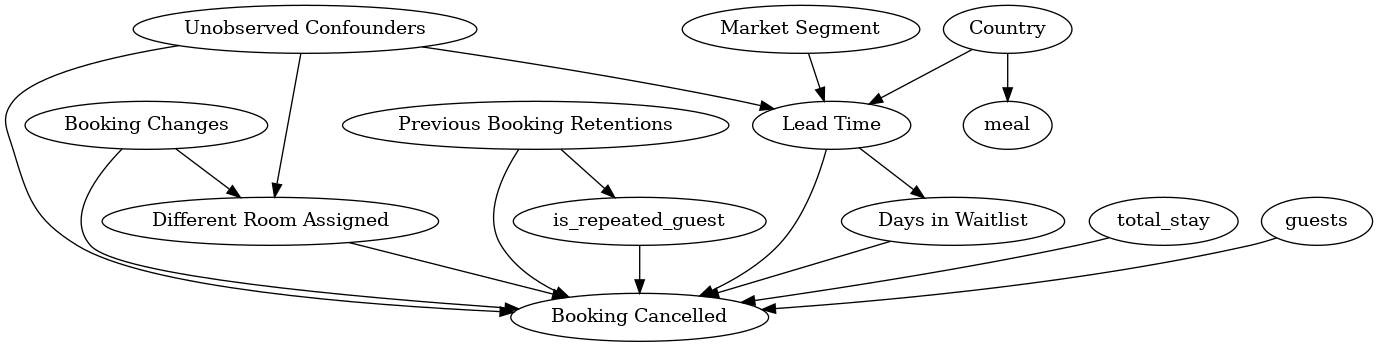

In [12]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Step-2. Identify the Causal Effect
We say that Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant.
Thus in this step, by using properties of the causal graph, we identify the causal effect to be estimated

In [13]:
#Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U', 'booking_changes']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                       
──────────────────────────(Expectation(is_canceled|booking_changes))
d[different_room_assigned]                                          
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,U) = P(is_canceled|different_room_assigned,booking_changes)
### Estimand : 2
Estimand name: iv
No such variable found!



## Step-3. Estimate the identified estimand

In [14]:
estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: is_canceled~different_room_assigned+booking_changes
/home/siddharth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddharth/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                       
──────────────────────────(Expectation(is_canceled|booking_changes))
d[different_room_assigned]                                          
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,booking_changes,U) = P(is_canceled|different_room_assigned,booking_changes)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: is_canceled~different_room_assigned+booking_changes
Target units: ate

## Estimate
Mean value: -0.36197744649725744



## Step-4. Refute results

Note that the causal part does not come from data. It comes from your *assumptions* that lead to *identification*. Data is simply used for statistical *estimation*. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

What happens when another common cause exists?
What happens when the treatment itself was placebo?

### Method-1
**Radom Common Cause:-** *Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn't change by much.*

In [15]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: is_canceled~different_room_assigned+booking_changes+w_random
/home/siddharth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddharth/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


Refute: Add a Random Common Cause
Estimated effect:-0.36197744649725744
New effect:-0.36202708070793355



### Method-2
**Placebo Treatment Refuter:-** *Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.*

In [16]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Binomial Distribution with 1 trials and 0.5 probability of success
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: is_canceled~placebo+booking_changes
/home/siddharth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddharth/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
INFO:dowhy.causal_refuters.placebo_treatmen

Refute: Use a Placebo Treatment
Estimated effect:-0.36197744649725744
New effect:0.0003854214540140934
p value:0.42



### Method-3
**Data Subset Refuter:-** *Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn't be much variation.*

In [17]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 95512.0 each
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: is_canceled~different_room_assigned+booking_changes
/home/siddharth/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/siddharth/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: is_canceled~different_room_assigned+booking_changes


Refute: Use a subset of data
Estimated effect:-0.36197744649725744
New effect:-0.3619892896443031
p value:0.49



This tells us that if the probability of cancellation was $0<x<1$, then changing the room causes the probability to go to $x+0.36$.

So the effect of our *treatment* is **36 percentage points**. 

## Comparing Results with XGBoost Feature Importance
We now know the effect of assigning a different room is 36 percentage points, so it might be a good exercise to compare results with feature importance obtained using a model offering high predictive accuracy on this dataset.

We choose XGBoost as the model as it offers a fairly high predictive accuracy on this dataset. The *plot_importance* function of XGBoost is used to calculate feature importance. Contrary to our analysis using *DoWhy*, it is observed that *Different_room_assigned* attains a relatively low importance score.

In [28]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot
# split data into X and y
X = dataset_copy
y = dataset_copy['is_canceled']
X = X.drop(['is_canceled'],axis=1)
# One-Hot Encode the dataset
X = pd.get_dummies(X)
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 86.40%
              precision    recall  f1-score   support

       False       0.88      0.90      0.89     14997
        True       0.83      0.80      0.81      8881

    accuracy                           0.86     23878
   macro avg       0.86      0.85      0.85     23878
weighted avg       0.86      0.86      0.86     23878



The feature importance plotted below uses **weight** to rank features. Here **weight** is the number of times a feature appears in a tree

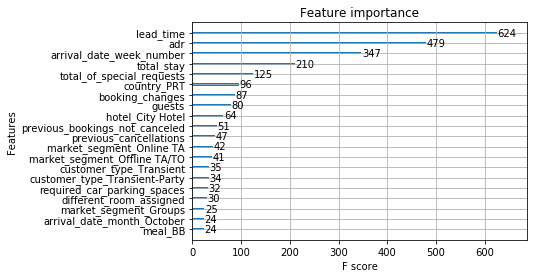

In [29]:
# plot feature importance
plot_importance(model,max_num_features=20)
pyplot.show()

In [30]:
# Execute this code to hide all warnings
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')